## Base models

In this notebook we will use some regression models to our data WITHOUT any tuning and data preprocessing (except missing value filling, encoding and scaling). Results which we will receive will be our base results which we will try to upgrade in the next notebooks

We will use 4 baseline models. DummyRegressor, Linear Regression (OLS), Ridge regression, and RandomForest regression. But it doesn't mean that we will not use some other models in future

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [9]:
RANDOM_STATE=1

## Content

In [2]:
data = pd.read_csv("data/filled/train.csv")
sub = pd.read_csv("data/filled/test.csv")

encoded_data = pd.read_csv("data/encoded/train.csv")
encoded_sub = pd.read_csv("data/encoded/test.csv")

scaled_data = pd.read_csv("data/scaled/train.csv")
scaled_sub = pd.read_csv("data/scaled/test.csv")

### Train/test split & scaling

In [10]:
X = encoded_data.drop(["SalePrice"], axis=1)
y = encoded_data["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

real_y_train = y_train.copy()
real_y_test = y_test.copy()

scaler = StandardScaler()

continuous_columns = data.select_dtypes(exclude="object").drop(["SalePrice", "Id", "MSSubClass"], axis=1).columns.values
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

y_train = np.log(y_train)
y_test = np.log(y_test)

X_train.shape

(1167, 316)

## DummyRegressor

In [4]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor().fit(X_train, y_train)

train_pred = dummy_reg.predict(X_train)
test_pred = dummy_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("."*40)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.3975265163728815
TEST LOG RMSE: 0.40741885860024457
........................................
TRAIN RMSE 81724.9360837574
TEST RMSE 75334.24405265198


This will be our "dummy" baseline

## OLS

In [11]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression().fit(X_train, y_train)

train_pred = linear_reg.predict(X_train)
test_pred = linear_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("."*40)
print("TRAIN RMSE:", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE:", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.08900924398760018
TEST LOG RMSE: 0.13749958161239084
........................................
TRAIN RMSE: 17623.11994714418
TEST RMSE: 21625.091522040417


## Ridge Regression

In [12]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X_train, y_train)

train_pred = ridge_reg.predict(X_train)
test_pred = ridge_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 40)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.09612357883578238
TEST LOG RMSE: 0.12982541244510395
........................................
TRAIN RMSE 19846.9789570854
TEST RMSE 21362.56046901175


## RandomForest regression

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)

train_pred = rf_reg.predict(X_train)
test_pred = rf_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 40)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.05481059719342915
TEST LOG RMSE: 0.13706657040050554
........................................
TRAIN RMSE 11749.129653478098
TEST RMSE 22713.391858047176


## Submission to kaggle

Before submission we will use the whole train dataset for training. Because of the fact that ols gives us overflow we will submit only ridge and random_forest. Dummy regressor is too dummy to submit :)

In [16]:
scaled_X = scaled_data.drop(["SalePrice"], axis=1)
scaled_y = scaled_data["SalePrice"]

ridge_reg = ridge_reg.fit(scaled_X, scaled_y)
ridge_sub = pd.Series(np.exp(ridge_reg.predict(scaled_sub)))
ridge_sub_df = pd.DataFrame()
ridge_sub_df["Id"] = sub["Id"]
ridge_sub_df["SalePrice"] = ridge_sub

rf_reg = rf_reg.fit(scaled_X, scaled_y)
rf_sub = pd.Series(np.exp(rf_reg.predict(scaled_sub)))
rf_sub_df = pd.DataFrame()
rf_sub_df["Id"] = sub["Id"]
rf_sub_df["SalePrice"] = rf_sub

ridge_sub_df.to_csv("submissions/baseline/ridge.csv", index=False)
rf_sub_df.to_csv("submissions/baseline/random_forest.csv", index=False)

We received the next results on Kaggle submission for Ridge regression and Random Forest regression:

**Ridge** &ndash; **0.14036**

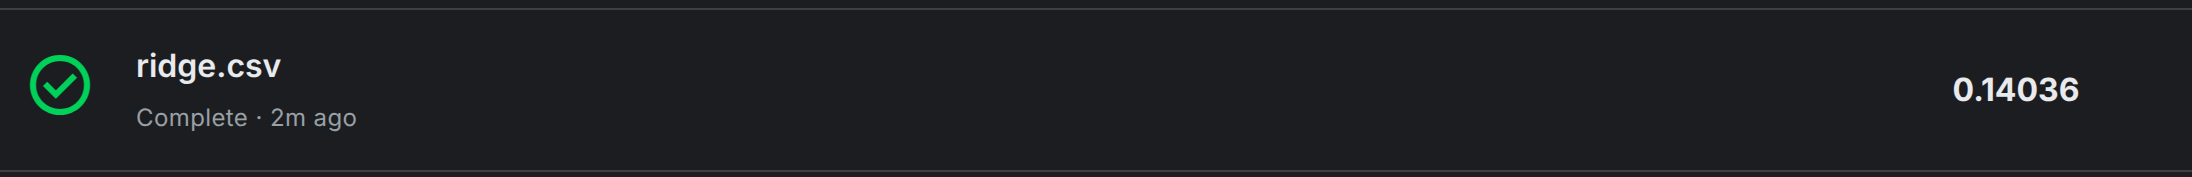

**RandomForest** &ndash; **0.14417**

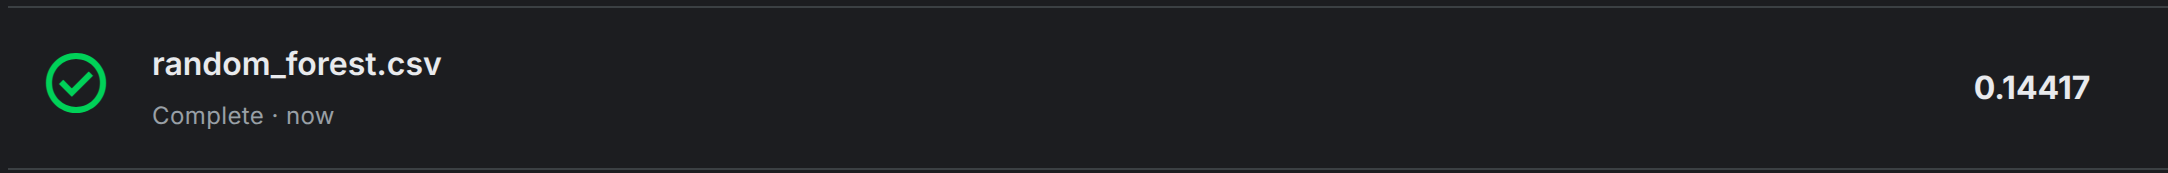